# Introduction

Today, internet and social media have become the fastest and easiest ways to get information. In this age, reviews, opinions, feedbacks, messages and recommendations have become significant source of information. Thanks to advancement in technologies, we are now able to extract meaningful information from such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI), makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detection and sentiment analysis, text generation, language translations and document classification.

To understand how we can use TensorFlow2 to build SMS spam detection model. Particularly, we will build a binary classification model to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn how to implement Dense, Long Short Term Memory (LSTM)  deep learning models in TensorFlow2 Keras API

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
%matplotlib inline
# library from train test split
from sklearn.model_selection import train_test_split

#deep learning libraries from text pre-procesing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Embedding
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer


# Read raw dataset

In [2]:
# we also use seperater to bulit a proper dataframe
messages = pd.read_csv("SMSSpamCollection", sep ='\t', names= ["label","message"])
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
messages.shape

(5572, 2)

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:7])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...


looks like we have some duplicate messages.

In [7]:
messages.label.unique()

array(['ham', 'spam'], dtype=object)

# Visualization

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


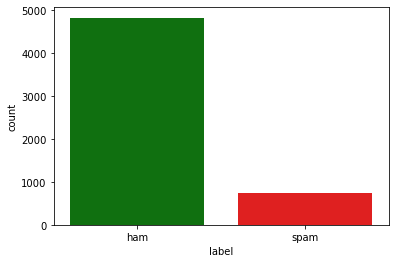

ham     4825
spam     747
Name: label, dtype: int64


In [8]:
sns.countplot(messages.label, palette = ["green", "red"])
plt.show()
print(messages.label.value_counts())

We have unbalanced labels, Later we have to balanced them.

In [9]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

In [10]:
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

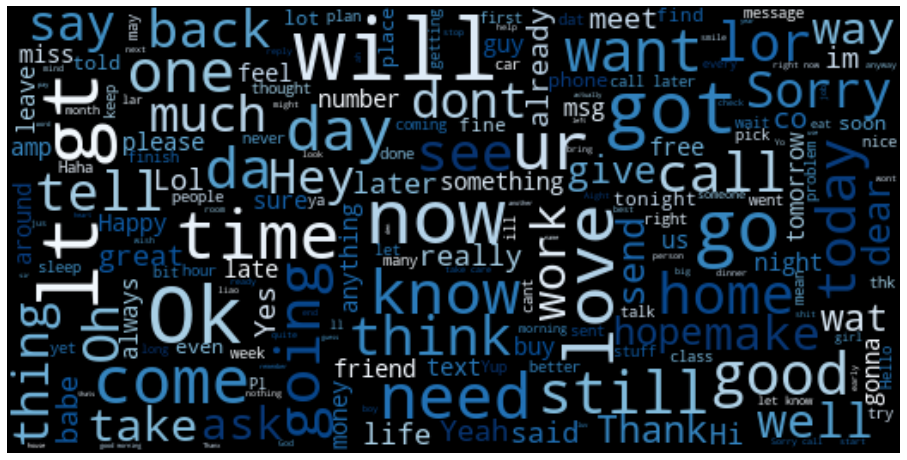

In [11]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The ham message WordCloud below shows that "now", "work", "How", "love", "Ok" and "Sorry" are the most commonly appeared word in ham messages.

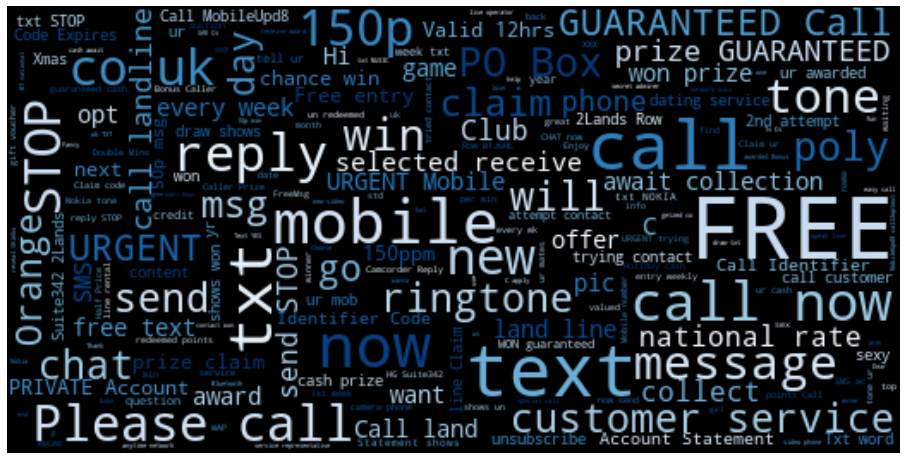

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud below shows that "Free", "call", "text", "claim" and "reply" are most commonly appeared words in spam messages.

# Drop duplicates

In [13]:
df = messages.drop_duplicates()

In [14]:
df.shape

(5169, 2)

In [15]:
messages.shape

(5572, 2)

In [16]:
from sklearn.utils import shuffle
df = shuffle(df)

In [17]:
dt = df.copy()

In [18]:
dt.head()

,label,message
757,ham,Cant think of anyone with * spare room off * t...
3908,ham,No that just means you have a fat head
3376,ham,:)
4779,ham,U R THE MOST BEAUTIFUL GIRL IVE EVER SEEN. U R...
4785,ham,Indeed and by the way it was either or - not b...


In [19]:
dt.reset_index(inplace=True)
dt

,index,label,message
0,757,ham,Cant think of anyone with * spare room off * t...
1,3908,ham,No that just means you have a fat head
2,3376,ham,:)
3,4779,ham,U R THE MOST BEAUTIFUL GIRL IVE EVER SEEN. U R...
4,4785,ham,Indeed and by the way it was either or - not b...
...,...,...,...
5164,469,ham,"Yup, no need. I'll jus wait 4 e rain 2 stop."
5165,3824,ham,Please protect yourself from e-threats. SIB ne...
5166,3929,ham,Babe ? I lost you ... Will you try rebooting ?
5167,4057,ham,"Ha ha nan yalrigu heltini..Iyo kothi chikku, u..."


# Text Pre-processing

In [20]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(txt):
    stripped = re.sub(r"<br />",' ',txt)
    text = re.sub(r'\d+', '', stripped)#remove numbers
    txt = "".join([c for c in text if c not in string.punctuation]) #remove punctuation
    tokens = nltk.word_tokenize(txt)# tokenizer
    text =  " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords]) #remove stopwords, #lemmatization
    return text 
dt["tok"] = dt["message"].apply(lambda x: clean_text(x.lower())) #lower


In [21]:
dt.head()

,index,label,message,tok
0,757,ham,Cant think of anyone with * spare room off * t...,cant think anyone spare room top head
1,3908,ham,No that just means you have a fat head,mean fat head
2,3376,ham,:),
3,4779,ham,U R THE MOST BEAUTIFUL GIRL IVE EVER SEEN. U R...,u r beautiful girl ive ever seen u r baby come...
4,4785,ham,Indeed and by the way it was either or - not b...,indeed way either


In [22]:
#save our pre-processed data
import pickle

pickle_out = open("sms.pickle","wb")
pickle.dump(dt,pickle_out)
pickle_out.close()

In [23]:
#load
import pickle
sms = pickle.load(open("sms.pickle","rb"))

In [24]:
sms

,index,label,message,tok
0,757,ham,Cant think of anyone with * spare room off * t...,cant think anyone spare room top head
1,3908,ham,No that just means you have a fat head,mean fat head
2,3376,ham,:),
3,4779,ham,U R THE MOST BEAUTIFUL GIRL IVE EVER SEEN. U R...,u r beautiful girl ive ever seen u r baby come...
4,4785,ham,Indeed and by the way it was either or - not b...,indeed way either
...,...,...,...,...
5164,469,ham,"Yup, no need. I'll jus wait 4 e rain 2 stop.",yup need ill jus wait e rain stop
5165,3824,ham,Please protect yourself from e-threats. SIB ne...,please protect ethreats sib never asks sensiti...
5166,3929,ham,Babe ? I lost you ... Will you try rebooting ?,babe lost try rebooting
5167,4057,ham,"Ha ha nan yalrigu heltini..Iyo kothi chikku, u...",ha ha nan yalrigu heltiniiyo kothi chikku u sh...


In [25]:
X = sms["tok"]
Y = sms["label"]

# train test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135,)
(4135,)
(1034,)
(1034,)


In [28]:
y_train.value_counts()

ham     3609
spam     526
Name: label, dtype: int64

In [29]:
y_test.value_counts()

ham     907
spam    127
Name: label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(y_train)
test_y = le.transform(y_test)

In [31]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=2000)
tfidf_vect.fit(sms['tok'])
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

We use OverSampling to solve imbalanced traning data

In [35]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

In [38]:
sm = SMOTE(random_state=777)
sm_xtrain_tfidf, sm_train_y = sm.fit_resample(xtrain_tfidf, train_y)

In [39]:
sm_xtrain_tfidf

<7218x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 74060 stored elements in Compressed Sparse Row format>